# Δ-Motif Tutorial: Part 2 - Quantum Circuit Layout Selection

## Learning Objectives

By the end of this notebook, you will:
1. Understand **quantum circuits** and how they map to graphs
2. Learn about **quantum device topologies** (connectivity constraints)
3. See how **circuit layout selection** is a subgraph isomorphism problem
4. Apply the **graphs-as-tables** approach to find all valid circuit mappings
5. Compare the number of valid layouts for different circuits


---
## 1. Setup & Introduction

### What is Quantum Circuit Layout Selection?

**Problem**: Quantum computers have physical constraints - not all qubits can interact directly. When we have a quantum circuit that needs specific qubit interactions, we must **map** (layout) the circuit onto the device topology.

**Key Insight**: This is a **subgraph isomorphism problem**!
- **Pattern graph**: The quantum circuit's qubit connectivity
- **Data graph**: The quantum device's physical topology
- **Goal**: Find all valid ways to map the circuit onto the device

**Why it matters**:
- Different layouts have different error rates
- Some layouts require fewer SWAP gates (cheaper)
- Finding ALL valid layouts lets us choose the best one

In [1]:
# Install dependencies (uncomment if needed)
# !pip install qiskit rustworkx pandas numpy matplotlib

In [2]:
import qiskit_ibm_runtime
from rustworkx import PyGraph
%load_ext autoreload
%autoreload 2

In [3]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler import CouplingMap

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## 2. Quick Introduction to Qiskit

**Qiskit** is IBM's open-source quantum computing framework. Key concepts:

- **Qubit**: The basic unit of quantum information (like a classical bit, but quantum)
- **Quantum Gate**: Operations on qubits (like logic gates in classical computing)
- **Quantum Circuit**: A sequence of gates applied to qubits
- **Two-qubit gates**: Gates that require interaction between two qubits (this creates the connectivity constraint!)

Let's create a simple quantum circuit!

Quantum Circuit:

📊 Circuit has 3 qubits
📊 Circuit has 3 gates total


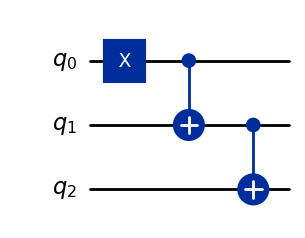

In [82]:
# Create a simple 3-qubit quantum circuit
qc = QuantumCircuit(3)

# Add some gates
qc.x(0)        # Hadamard gate on qubit 0
qc.cx(0, 1)    # CNOT gate between qubits 1 and 2 (requires connectivity!)
qc.cx(1, 2)    # CNOT gate between qubits 1 and 2 (requires connectivity!)

# Draw the circuit
print("Quantum Circuit:")
print(f"\n📊 Circuit has {qc.num_qubits} qubits")
print(f"📊 Circuit has {qc.size()} gates total")
qc.draw(output='mpl')


### Understanding Quantum Gates

**X Gate (NOT gate)**:
- The quantum equivalent of a classical NOT gate
- Flips a qubit's state: |0⟩ → |1⟩ and |1⟩ → |0⟩
- Single-qubit operation (no connectivity constraint)
- In the circuit above: `qc.x(0)` applies an X gate to qubit 0

**CNOT Gate (CX - Controlled-NOT)**:
- A **two-qubit gate** that requires physical interaction between qubits
- Has a **control qubit** and a **target qubit**
- Operation: If control qubit is |1⟩, flip the target qubit; otherwise do nothing
- In the circuit above: `qc.cx(0, 1)` means "qubit 0 controls, qubit 1 is target"
- **This creates a connectivity requirement** - qubits 0 and 1 must be able to interact!

**CNOT Truth Table**:
```
Control | Target | → | Control | Target
   0    |   0    |   |    0    |   0
   0    |   1    |   |    0    |   1
   1    |   0    |   |    1    |   1    (target flipped)
   1    |   1    |   |    1    |   0    (target flipped)
```

**Other gates**: There are many other quantum gates (Hadamard, Phase, T, SWAP, etc.), but CNOT and other two-qubit gates are what matter for layout selection since they define which qubits need to be physically connected.

---
## 3. Quantum Circuits as Graphs

### From Circuits to Graphs: The Key Transformation

A quantum circuit contains many gates, but for **layout selection**, we only care about which qubits need to interact. This is where the circuit-to-graph transformation becomes powerful!

**The Mapping**:
- **Nodes (vertices)** = Qubits in the circuit
- **Edges** = Pairs of qubits that have at least one two-qubit gate between them

**Important observations**:

1. **Single-qubit gates are ignored** (X, H, T, etc.)
   - They don't require connectivity, so they don't affect layout

2. **Multiple gates between same qubits = one edge**
   - If qubits 0 and 1 have 5 different CNOT gates, that's still just one edge in the graph
   - The graph captures "do these qubits need to interact?" not "how many times?"

3. **The graph is undirected**
   - CNOT(0,1) and CNOT(1,0) both require the same physical connectivity
   - Direction matters for the gate, but not for the layout

**Example from our circuit above**:
```
Circuit gates:           Graph representation:
  X(0)          →        Node 0 (no edge, single-qubit gate)
  CNOT(0,1)     →        Edge between nodes 0 and 1
  CNOT(1,2)     →        Edge between nodes 1 and 2
```

Result: A graph with 3 nodes (qubits 0, 1, 2) and 2 edges (0-1, 1-2) forming a **linear path**.


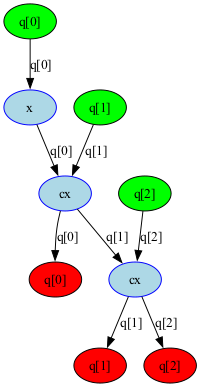

In [83]:
# Let's start by converting our quantum circuit to a graph
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
dag: DAGCircuit = circuit_to_dag(qc)
dag.draw()


**🎯 This circuit graph is our PATTERN that we need to find in the device topology!**

Let's extract this connectivity graph from our circuit!


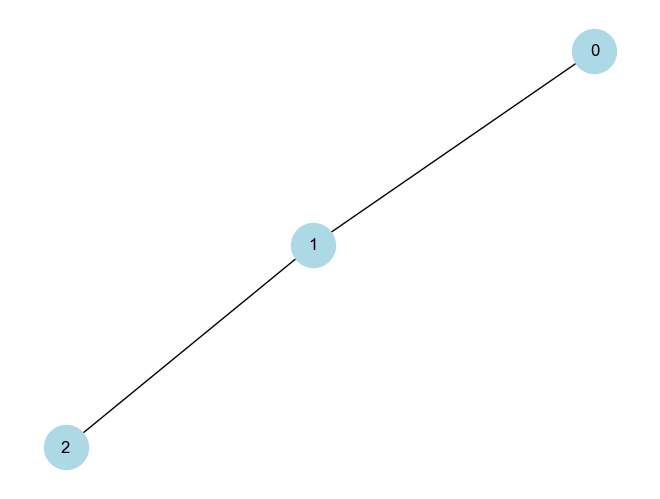

In [84]:
def get_interacting_qubits(dag: DAGCircuit) -> rx.PyGraph:
    """Extract pairs of qubits that interact via two-qubit gates."""
    interactions = set()
    graph = rx.PyGraph()
    for _ in range(dag.num_qubits()):
        graph.add_node(None)

    for node in dag.op_nodes():
        if len(node.qargs) == 2:
            q0, _ = dag.find_bit(node.qargs[0])
            q1, _ = dag.find_bit(node.qargs[1])
            interactions.add((q0, q1))

    for q0, q1 in interactions:
        graph.add_edge(q0, q1, None)

    return graph

circuit_graph = get_interacting_qubits(dag)
mpl_draw(circuit_graph, with_labels=True, node_size=1000, node_color='lightblue')



---
## 4. Quantum Device Topologies

Real quantum computers have **physical connectivity constraints**. Not all qubits can interact directly!

Common topologies:
- **Linear/Path**: Qubits in a line (0-1-2-3-4)
- **Grid**: Qubits in a 2D lattice
- **Heavy-Hex**: IBM's specialized topology for error correction
- **All-to-all**: Fully connected (rare, mostly ion trap systems)

Let's visualize different device topologies!

In [12]:
def get_coupling_map_from_devices()-> dict[str, CouplingMap]:
    """Get the coupling map of a fake IBM quantum device."""
    from qiskit_ibm_runtime import fake_provider
    res = {}
    for dev in dir(fake_provider):
        if dev.startswith("Fake"):
            fake_device = getattr(fake_provider, dev)()
            if not hasattr(fake_device, "configuration"):
                continue
            coupling_map = fake_device.configuration().coupling_map
            device_graph = CouplingMap(coupling_map)
            res[dev] = device_graph
    return res
device_and_coupling_maps = get_coupling_map_from_devices()
print(list(device_and_coupling_maps.keys()))

['FakeAlgiers', 'FakeAlmadenV2', 'FakeArmonkV2', 'FakeAthensV2', 'FakeAuckland', 'FakeBelemV2', 'FakeBoeblingenV2', 'FakeBogotaV2', 'FakeBrisbane', 'FakeBrooklynV2', 'FakeBurlingtonV2', 'FakeCairoV2', 'FakeCambridgeV2', 'FakeCasablancaV2', 'FakeCusco', 'FakeEssexV2', 'FakeFez', 'FakeFractionalBackend', 'FakeGeneva', 'FakeGuadalupeV2', 'FakeHanoiV2', 'FakeJakartaV2', 'FakeJohannesburgV2', 'FakeKawasaki', 'FakeKolkataV2', 'FakeKyiv', 'FakeKyoto', 'FakeLagosV2', 'FakeLimaV2', 'FakeLondonV2', 'FakeManhattanV2', 'FakeManilaV2', 'FakeMarrakesh', 'FakeMelbourneV2', 'FakeMontrealV2', 'FakeMumbaiV2', 'FakeNairobiV2', 'FakeOsaka', 'FakeOslo', 'FakeOurenseV2', 'FakeParisV2', 'FakePeekskill', 'FakePerth', 'FakePoughkeepsieV2', 'FakePrague', 'FakeQuebec', 'FakeQuitoV2', 'FakeRochesterV2', 'FakeRomeV2', 'FakeSantiagoV2', 'FakeSherbrooke', 'FakeSingaporeV2', 'FakeSydneyV2', 'FakeTorino', 'FakeTorontoV2', 'FakeValenciaV2', 'FakeVigoV2', 'FakeWashingtonV2', 'FakeYorktownV2']


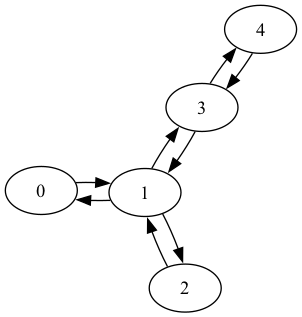

In [21]:
device_and_coupling_maps['FakeQuitoV2'].draw()

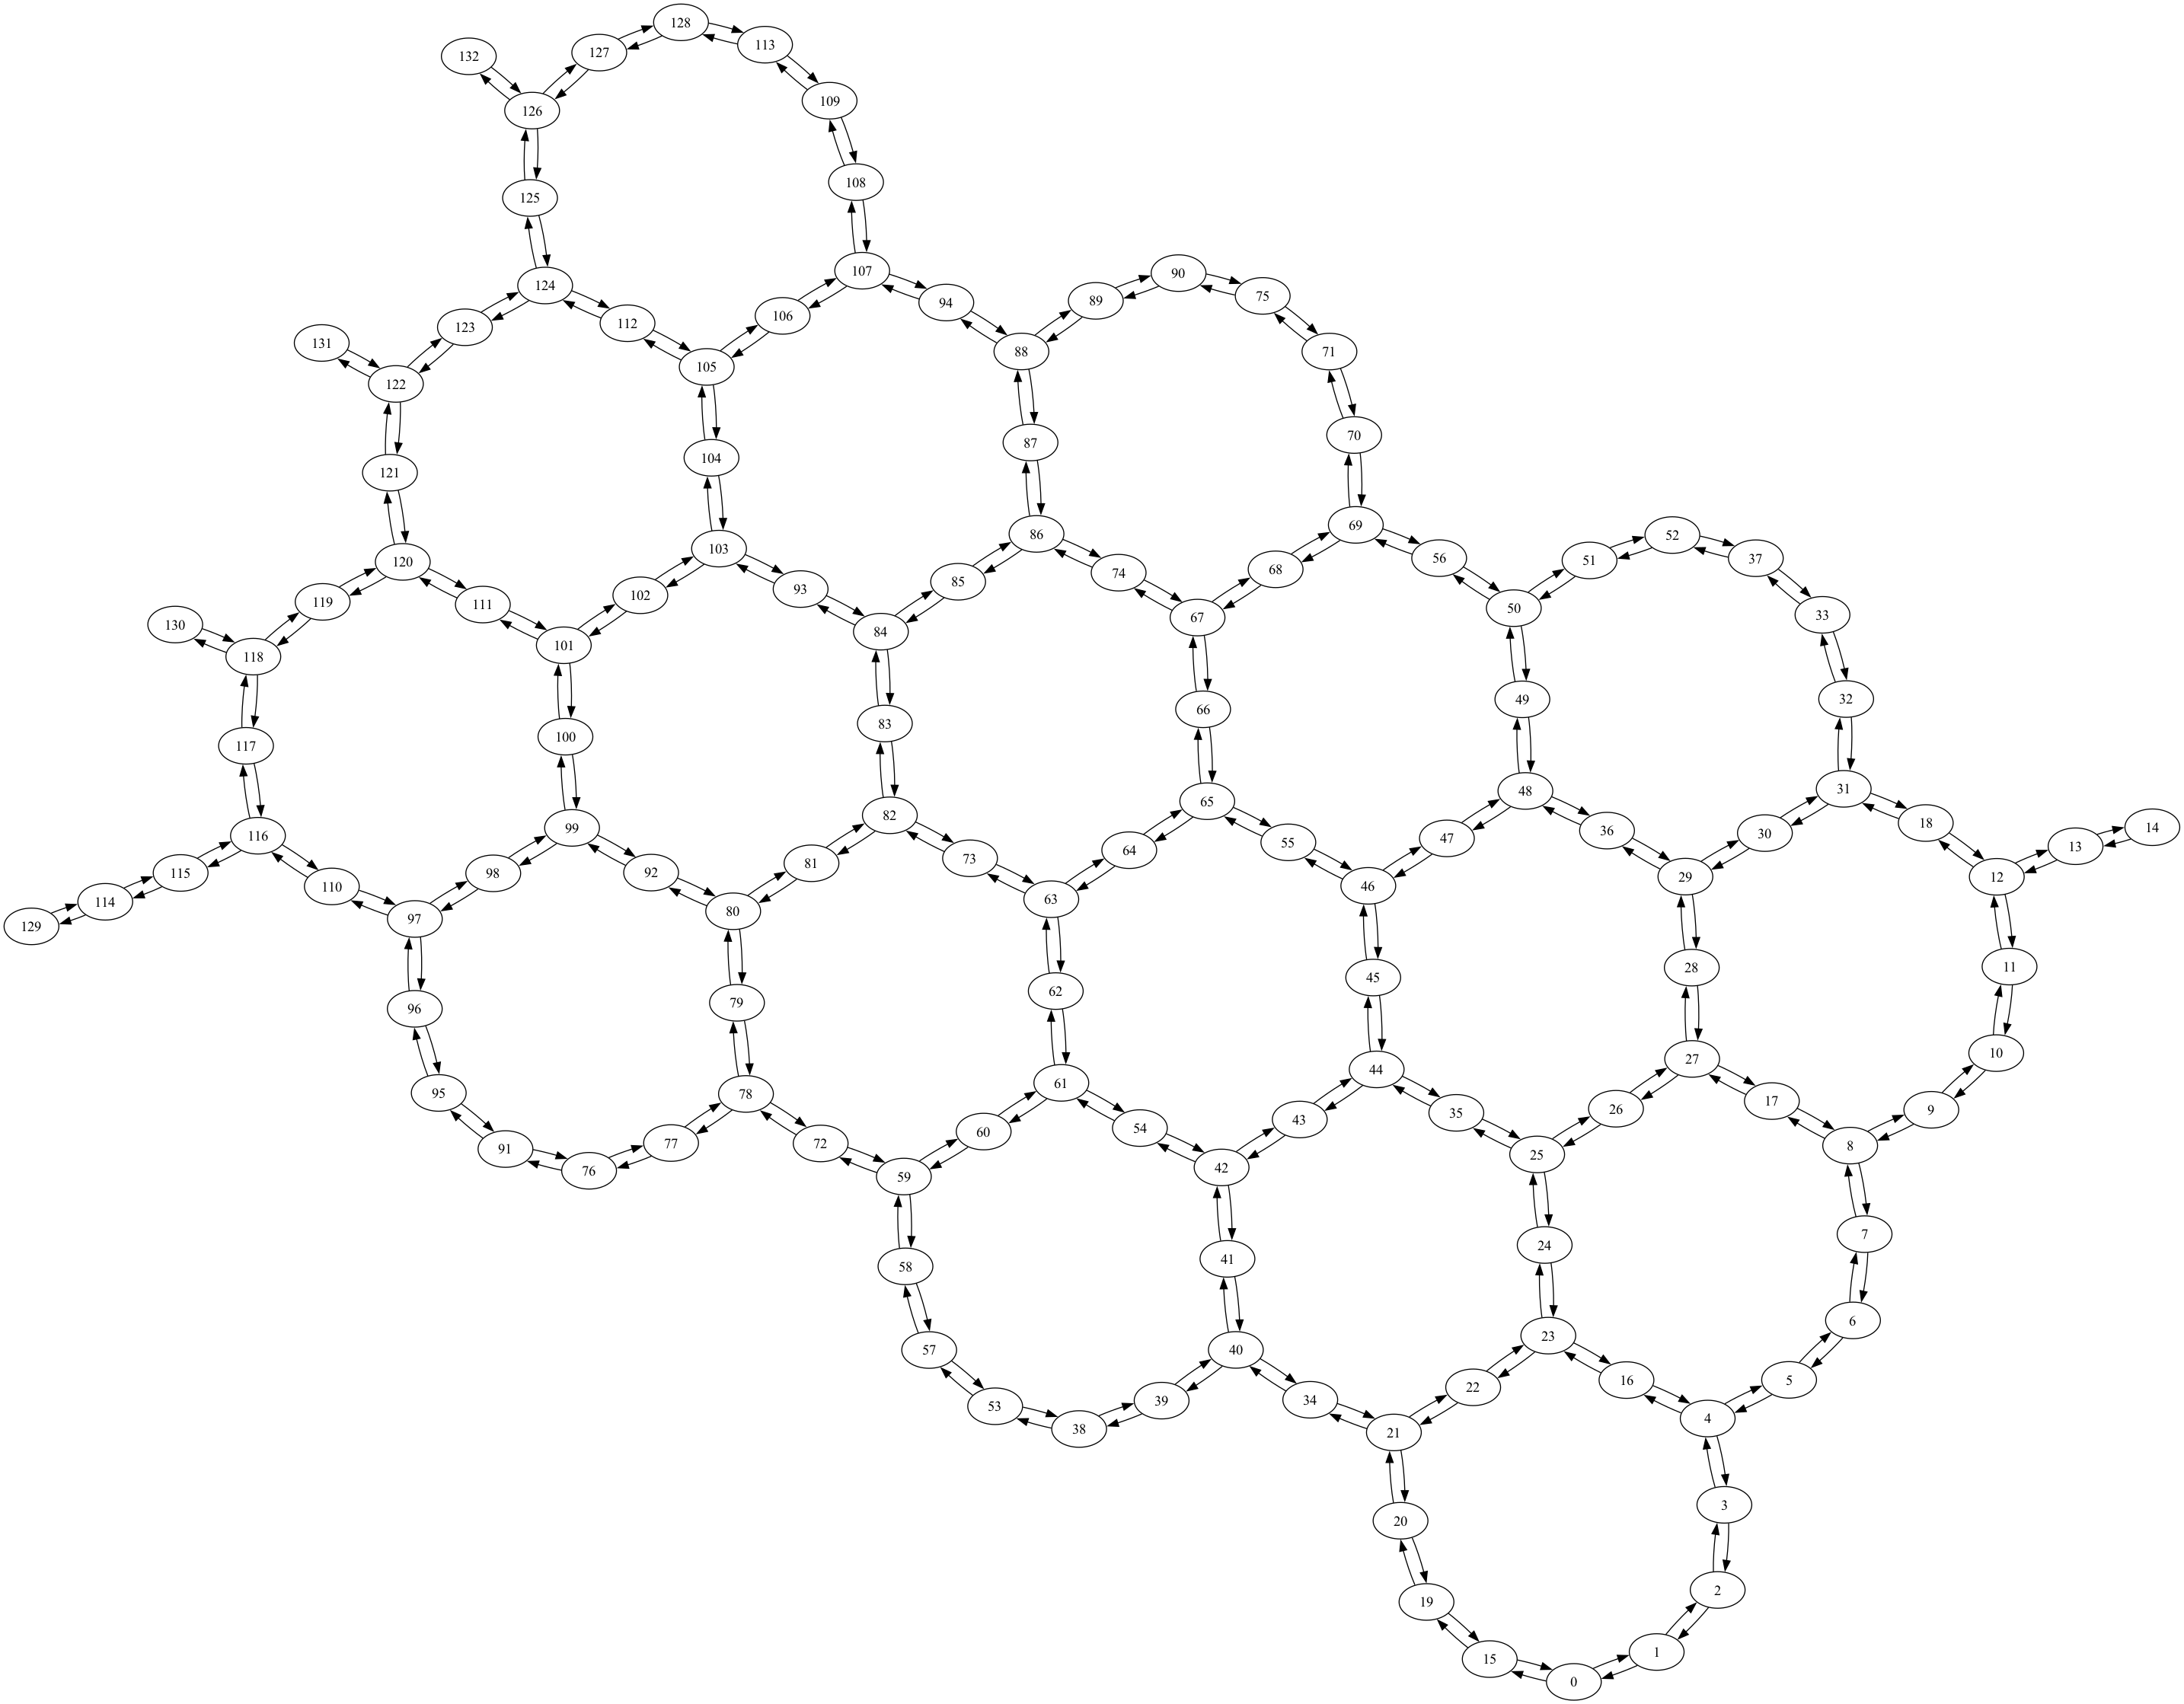

In [19]:
device_and_coupling_maps['FakeTorino'].draw()


---
## 5. The Layout Selection Problem

**Question**: Given our circuit (pattern graph) and a device topology (data graph), how many valid ways can we map the circuit onto the device?

This is **subgraph isomorphism**!

Let's use VF2 first to see how it works:

📊 Heavy-Hex Lattice:
   Qubits: 19
   Connections: 20


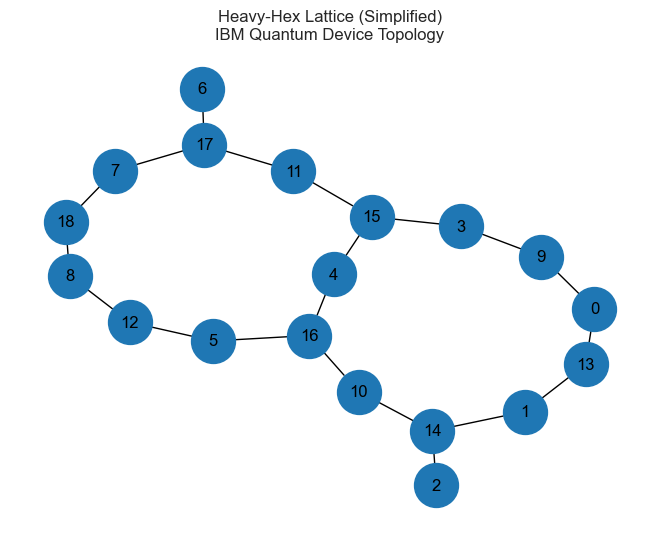

In [111]:
import rustworkx.generators as generators
heavy_hex = generators.heavy_hex_graph(3)

print(f"📊 Heavy-Hex Lattice:")
print(f"   Qubits: {heavy_hex.num_nodes()}")
print(f"   Connections: {heavy_hex.num_edges()}")

mpl_draw(heavy_hex, with_labels=True, node_size=1000, node_color='#1f77b4')
plt.title("Heavy-Hex Lattice (Simplified)\nIBM Quantum Device Topology")
plt.show()

In [130]:
# Let's map our 3-qubit circuit onto the linear device
print("🔍 Finding all valid layouts using VF2...\n")

def find_mappings(device: rx.PyGraph, circuit: rx.PyGraph) -> List[tuple]:
    """Find all valid mappings of the circuit onto the device using VF2."""
    # Find all valid mappings
    mappings = list(rx.vf2_mapping(device, circuit, subgraph=True))
    new_mappings = set()
    # Avoid duplicates for undirected graphs
    for i, mapping in enumerate(mappings):
        layout = {v: k for k, v in mapping.items()}  # Flip to {device: circuit}
        new_mapping = (tuple(sorted(layout.keys())), tuple(sorted(layout.values())))
        if not new_mapping in new_mappings:
            new_mappings.add(new_mapping)
    new_mappings = list(new_mappings)
    return new_mappings


vf2_mappings = find_mappings(heavy_hex, circuit_graph)
print(f"✅ Found {len(vf2_mappings)} valid layouts!\n")
print("First 5 valid layouts:")
for i, mapping in enumerate(vf2_mappings[:5]):
    print(f"  Layout {i+1}: Circuit qubits {mapping[0]} → Device qubits {mapping[1]}")

🔍 Finding all valid layouts using VF2...

✅ Found 25 valid layouts!

First 5 valid layouts:
  Layout 1: Circuit qubits (0, 1, 2) → Device qubits (8, 12, 18)
  Layout 2: Circuit qubits (0, 1, 2) → Device qubits (3, 9, 15)
  Layout 3: Circuit qubits (0, 1, 2) → Device qubits (4, 10, 16)
  Layout 4: Circuit qubits (0, 1, 2) → Device qubits (5, 8, 12)
  Layout 5: Circuit qubits (0, 1, 2) → Device qubits (6, 11, 17)


### Visualizing Different Layouts

Let's visualize what these different mappings mean:

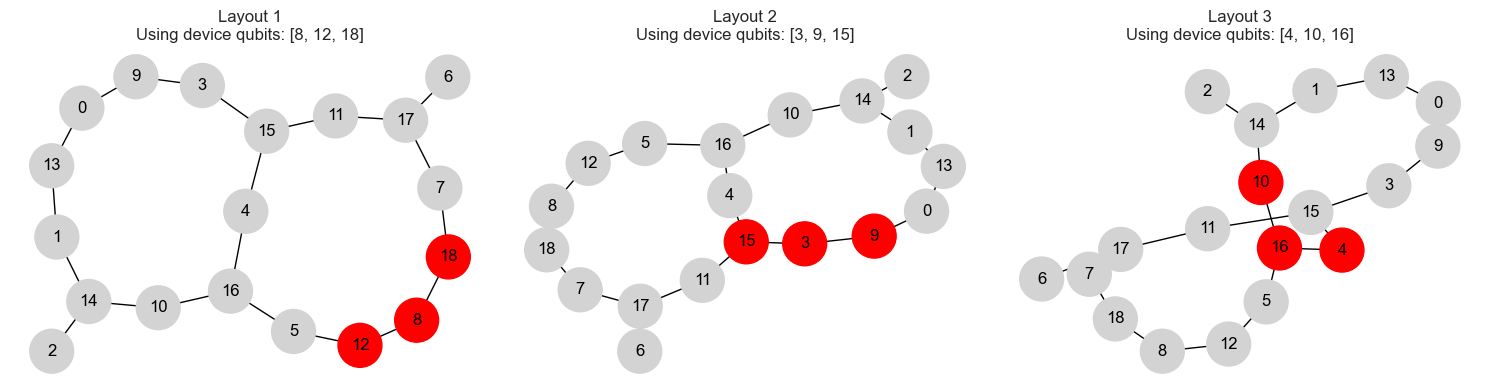

🔴 Red nodes = qubits used by the circuit
⚪ Gray nodes = unused device qubits


In [131]:
# Visualize first 3 mappings
def visualize_mappings(mappings: List[tuple], device: rx.PyGraph):
    """Visualize the first 3 mappings on the device graph."""
    if len(mappings) >= 3:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        for idx in range(min(3, len(mappings))):
            mapping = mappings[idx]
            # Create a copy of the device and highlight the mapped qubits
            device_qubits = list(mapping)

            # Color nodes based on mapping
            node_colors = ['red' if i in device_qubits else 'lightgray'
                          for i in heavy_hex.node_indices()]

            mpl_draw(device, ax=axes[idx], with_labels=True,
                    node_size=1000, node_color=node_colors)
            axes[idx].set_title(f"Layout {idx+1}\nUsing device qubits: {sorted(device_qubits)}")

        plt.tight_layout()
        plt.show()

        print("🔴 Red nodes = qubits used by the circuit")
        print("⚪ Gray nodes = unused device qubits")
visualize_mappings([dev_qb for _, dev_qb in vf2_mappings], heavy_hex)

---
### 🎯 Exercise: Compare Topologies

Different device topologies can fit different circuit patterns! Let's explore how topology affects the number of valid layouts.

**Your task**: For each circuit pattern below, count how many valid layouts exist on **two different device topologies**:
- **Grid topology** (2x3 grid = 6 qubits)
- **FakeQuito** (IBM's 5-qubit device)

**Circuit patterns to try**:
1. **Edge**: 2 qubits connected (simplest)
2. **Path**: 3 qubits in a line (0-1-2)
3. **Triangle**: 3 qubits all connected to each other

**Questions to think about**:
- Which topology supports more valid layouts for each pattern?
- Why might one topology be better than another for certain patterns?

In [ ]:
# Create the two device topologies
grid_device = rx.generators.grid_graph(2, 3)  # 2x3 grid = 6 qubits
quito_device = device_and_coupling_maps['FakeQuitoV2'].graph

print("📊 Device Topologies:")
print(f"   Grid: {grid_device.num_nodes()} qubits, {grid_device.num_edges()} edges")
print(f"   FakeQuito: {quito_device.num_nodes()} qubits, {quito_device.num_edges()} edges\n")

# Visualize the devices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mpl_draw(grid_device, ax=axes[0], with_labels=True, node_size=800, node_color='lightblue')
axes[0].set_title("Grid Topology (2x3)")
mpl_draw(quito_device, ax=axes[1], with_labels=True, node_size=800, node_color='lightgreen')
axes[1].set_title("FakeQuito Topology")
plt.tight_layout()
plt.show()


def create_path_pattern():
    """3 qubits in a line"""
    p = rx.PyGraph()
    p.add_nodes_from([0, 1, 2])
    p.add_edge(0, 1, None)
    p.add_edge(1, 2, None)
    return p


def create_t_pattern():
    """3 qubits all connected"""
    p = rx.PyGraph()
    p.add_nodes_from([0, 1, 2, 3])
    p.add_edge(0, 1, None)
    p.add_edge(1, 2, None)
    p.add_edge(1, 3, None)
    return p


path_pattern = create_path_pattern()
t_pattern = create_t_pattern()

print("\n🔍 Circuit Patterns:")
print(f"   Path: {path_pattern.num_nodes()} qubits, {path_pattern.num_edges()} edges")
print(f"   T: {t_pattern.num_nodes()} qubits, {t_pattern.num_edges()} edges")

# TODO: Use find_mappings() to count valid layouts for each combination
# Example for edge pattern on grid:
# grid_edge_mappings = find_mappings(grid_device, edge_pattern)
# print(f"\nEdge on Grid: {len(grid_edge_mappings)} valid layouts")

# TODO: Complete the rest!
# Hint: You have 2 devices × 2 patterns = 4 combinations to check

print("\n" + "=" * 50)
print("YOUR RESULTS:")
print("=" * 50)
# TODO: Fill in your counts
# print(f"Edge pattern:")
# print(f"  Grid device: ??? valid layouts")
# print(f"  Quito device: ??? valid layouts")
# print(f"\nPath pattern:")
# print(f"  Grid device: ??? valid layouts")
# print(f"  Quito device: ??? valid layouts")
# print(f"\nTriangle pattern:")
# print(f"  Grid device: ??? valid layouts")
# print(f"  Quito device: ??? valid layouts")


---
## 8. Using the Δ-Motif Approach

Now let's apply the **graphs-as-tables** approach we learned in Notebook #1 to find all valid layouts!


First we'll try it with simple python loops to illustrate the concept.

✅ Found 25 valid layouts!

First 5 valid layouts:
  Layout 1: Circuit qubits (0, 1, 2) → Device qubits (0, 3, 9)
  Layout 2: Circuit qubits (0, 1, 2) → Device qubits (4, 15, 16)
  Layout 3: Circuit qubits (0, 1, 2) → Device qubits (1, 2, 14)
  Layout 4: Circuit qubits (0, 1, 2) → Device qubits (1, 13, 14)
  Layout 5: Circuit qubits (0, 1, 2) → Device qubits (0, 9, 13)


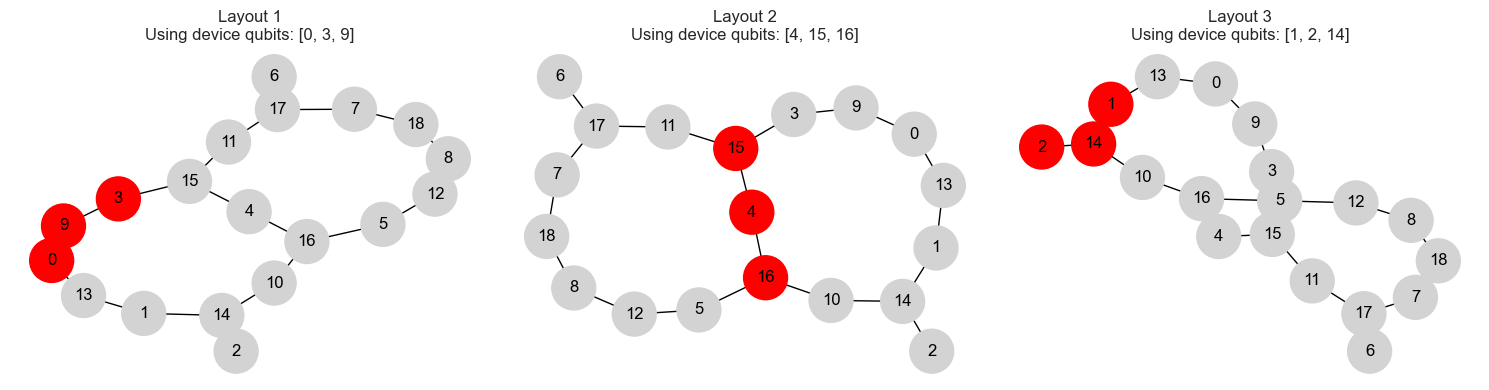

🔴 Red nodes = qubits used by the circuit
⚪ Gray nodes = unused device qubits


In [132]:
# Let's try the first method.
# Find all 2-hop paths in the device
# Below with python loops for clarity; in practice, use DataFrame joins for efficiency
def find_2hop_paths(device_graph: rx.PyGraph) -> list[tuple]:
    """Find all 2-hop paths in the device DataFrame."""
    # First make the dataframe into a list of edged
    edges = []
    for u, v in device_graph.edge_list():
        edges.append((u,v))
        edges.append((v,u))
    results = set()
    for src, dst in edges:
        for src2, dst2 in edges:
            # Make sure you have an overlapping node and
            # it is not loop
            if src2 == dst and dst2 != src:
                path = tuple(sorted((src, dst, dst2)))
                results.add(path)
    return list(results)
python_loop_mappings = find_2hop_paths(heavy_hex)
print(f"✅ Found {len(python_loop_mappings)} valid layouts!\n")
print("First 5 valid layouts:")
for i, mapping in enumerate(python_loop_mappings[:5]):
    print(f"  Layout {i+1}: Circuit qubits {(0,1,2)} → Device qubits {mapping}")
visualize_mappings(python_loop_mappings, heavy_hex)


### Finding Valid Mappings with JOINs

For our 3-qubit circuit, we need to find device qubits that form a line.

The approach:
1. Find all 2-hop paths in the device
3. That's our valid mapping!
OR

1. Find 2 1-hop path that share a node

In [133]:
def graph_to_dataframe(graph: rx.PyGraph) -> pd.DataFrame:
    """
    Convert a graph to a bidirectional edge DataFrame.
    For each edge (u,v), we include both (u,v) and (v,u) for undirected graphs.
    """
    edges = []
    for u, v in graph.edge_list():
        edges.append((u, v))
        edges.append((v, u))  # Add reverse for undirected

    return pd.DataFrame(edges, columns=['src', 'dst'])

# Convert linear device to DataFrame
device_df = graph_to_dataframe(heavy_hex)

print("📊 Device topology as a table:")
print(device_df.head(10))
print(f"\nTotal edges (bidirectional): {len(device_df)}")

📊 Device topology as a table:
   src  dst
0    0   13
1   13    0
2    1   13
3   13    1
4    1   14
5   14    1
6    2   14
7   14    2
8    3   15
9   15    3

Total edges (bidirectional): 40


## Dataframes

Now le'ts implement the 2-hop path finding using DataFrame JOINs!

✅ Found 25 valid layouts!

First 5 valid layouts:
  Layout 1: Circuit qubits (0, 1, 2) → Device qubits (0, 1, 13)
  Layout 2: Circuit qubits (0, 1, 2) → Device qubits (0, 9, 13)
  Layout 3: Circuit qubits (0, 1, 2) → Device qubits (1, 13, 14)
  Layout 4: Circuit qubits (0, 1, 2) → Device qubits (1, 2, 14)
  Layout 5: Circuit qubits (0, 1, 2) → Device qubits (1, 10, 14)


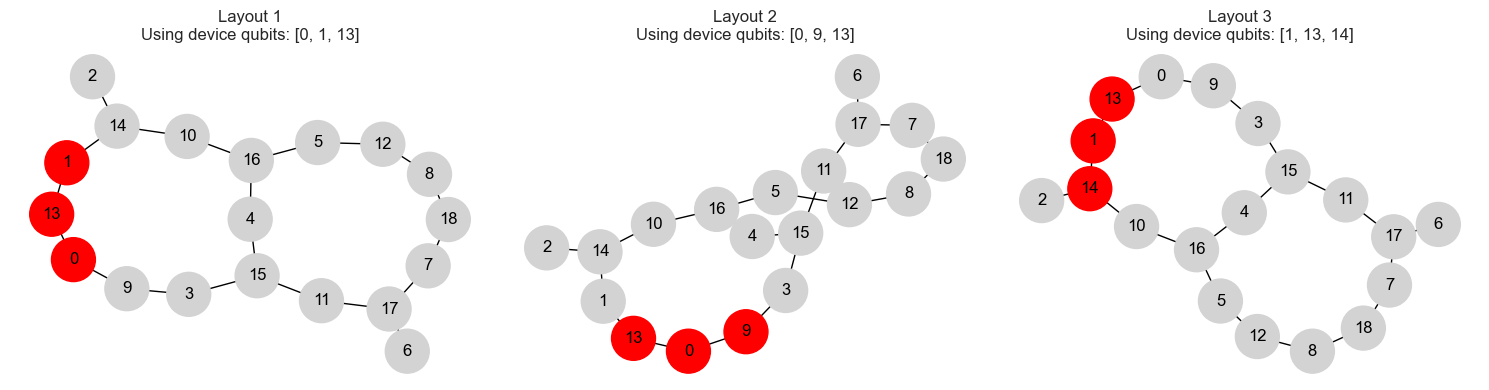

🔴 Red nodes = qubits used by the circuit
⚪ Gray nodes = unused device qubits


In [135]:
def find_2hop_paths_dataframe(device_df: pd.DataFrame) -> pd.DataFrame:
    """Find all 2-hop paths in the device DataFrame using JOINs."""
    # First join on dst to src to find 2-hop paths
    df1 = device_df.rename(columns={'src': 'src1', 'dst': 'mid'})
    df2 = device_df.rename(columns={'src': 'mid', 'dst': 'dst2'})

    # Join on the middle node
    joined = pd.merge(df1, df2, on='mid')

    # Filter out loops (src1 != dst2)
    joined = joined[joined['src1'] != joined['dst2']]

    # Select relevant columns and sort to avoid duplicates
    joined['path'] = joined.apply(lambda row: tuple(sorted((row['src1'], row['mid'], row['dst2']))), axis=1)
    unique_paths = joined[['path']].drop_duplicates().reset_index(drop=True)

    return unique_paths
df_2hop_paths = find_2hop_paths_dataframe(device_df)
print(f"✅ Found {len(df_2hop_paths)} valid layouts!\n")
print("First 5 valid layouts:")
valid_paths = df_2hop_paths['path'].to_list()
for i, mapping in enumerate(valid_paths[:5]):
    print(f"  Layout {i+1}: Circuit qubits {(0,1,2)} → Device qubits {mapping}")
visualize_mappings(valid_paths, heavy_hex)

---
### 🎯 Exercise: Find 3-Hop Paths (4-Qubit Circuits)

You've found 2-hop paths (3-qubit linear circuits). Now extend this to find **3-hop paths** (4-qubit linear circuits)!

**Pattern**: 4 qubits in a line
```
0 - 1 - 2 - 3
```

**Key insight**: A 3-hop path is a 2-hop path plus one more edge!

**Your task**:
1. Take the 2-hop paths you already found
2. Join them with the edge DataFrame
3. Match where the end of the 2-hop path connects to the start of an edge
4. Filter out loops (start ≠ end)
5. Count how many valid 3-hop paths exist in the heavy-hex device

In [139]:
# We have device_df (edges) and df_2hop_paths from earlier
print("📊 Available DataFrames:")
print(f"   device_df: {len(device_df)} edges")
print(f"   df_2hop_paths: {len(df_2hop_paths)} 2-hop paths\n")

# Extract 2-hop paths into columns for easier joining
paths_2hop_expanded = pd.DataFrame(
    df_2hop_paths['path'].tolist(),
    columns=['src1', 'mid', 'dst2']
)
print("2-hop paths (expanded):")
print(paths_2hop_expanded.head())

# TODO: Join 2-hop paths with edges to create 3-hop paths
# Hint: Match where dst2 (end of 2-hop) equals src (start of edge)
#
# paths_3hop = paths_2hop_expanded.merge(
#     device_df,
#     left_on='???',      # Which column from 2-hop paths?
#     right_on='???',     # Which column from edges?
# )

# TODO: Filter out loops (start should not equal end)
# Hint: src1 should not equal dst
# paths_3hop = paths_3hop[paths_3hop['???'] != paths_3hop['???']]

# TODO: Print results
# print(f"\n✅ Found {len(paths_3hop)} valid 3-hop paths!")
# print("\nFirst few 3-hop paths:")
# print(paths_3hop[['src1', 'mid', 'dst2', 'dst']].head(10))

📊 Available DataFrames:
   device_df: 40 edges
   df_2hop_paths: 25 2-hop paths

2-hop paths (expanded):
   src1  mid  dst2
0     0    1    13
1     0    9    13
2     1   13    14
3     1    2    14
4     1   10    14


---
## 10. Why This Matters: Layout Quality

Different layouts have different qualities:
- **Error rates**: Some physical qubits have better coherence
- **Gate fidelity**: Some qubit pairs have better gate performance
- **Circuit depth**: Some layouts require fewer SWAP gates

By finding **all** valid layouts, we can choose the best one based on device calibration data!